## Prepare

### Resources Paths

In [1]:
import glob

PROJECT_ROOT_PATH = '../../../..'
TEMP_PATH = PROJECT_ROOT_PATH + '/tmp'
DATA_PATH  = TEMP_PATH + '/detect/data'
MODEL_PATH = TEMP_PATH + '/detect/model'

WORDS_TRAIN_PATH = DATA_PATH + '/words.train.tsv'
WORDS_TEST_PATH = DATA_PATH + '/words.test.tsv'
LABELS_TRAIN_PATH = DATA_PATH + '/labels.train.tsv'
LABELS_TEST_PATH = DATA_PATH + '/labels.test.tsv'

FEATURES_TEST_PATH = sorted(glob.glob(DATA_PATH + "/*Feature*"))

print(len(FEATURES_TEST_PATH))

42


In [2]:
import os

for path in FEATURES_TEST_PATH:
    print(os.path.basename(path)[:-4])

ApproximateContextCoherenceFeature$bigram
ApproximateContextCoherenceFeature$fivegram
ApproximateContextCoherenceFeature$fourgram
ApproximateContextCoherenceFeature$trigram
CharacterExistenceFeature$123
CharacterExistenceFeature$124
CharacterExistenceFeature$125
CharacterExistenceFeature$126
CharacterExistenceFeature$32
CharacterExistenceFeature$33
CharacterExistenceFeature$34
CharacterExistenceFeature$35
CharacterExistenceFeature$36
CharacterExistenceFeature$37
CharacterExistenceFeature$38
CharacterExistenceFeature$39
CharacterExistenceFeature$40
CharacterExistenceFeature$41
CharacterExistenceFeature$42
CharacterExistenceFeature$43
CharacterExistenceFeature$44
CharacterExistenceFeature$45
CharacterExistenceFeature$46
CharacterExistenceFeature$47
CharacterExistenceFeature$58
CharacterExistenceFeature$59
CharacterExistenceFeature$60
CharacterExistenceFeature$61
CharacterExistenceFeature$62
CharacterExistenceFeature$63
CharacterExistenceFeature$64
CharacterExistenceFeature$91
CharacterEx

### Evaluation Data

We tokenize the OCR text using the proposed unsupervised segmentation approach.
Each token is labeled according to whether overlapping with any ground truth error.
We then split the token sequence at the position after the first 80% of the ground truth errors are encountered and use two splits for training and testing respectively.

In [3]:
import csv
import pandas as pd

def read_words(path):
    col_names = ["w-4", "w-3", "w-2", "w-1", "w", "w+1", "w+2", "w+3", "pos"]
    return pd.read_table(open(path, 'r'), header=None, quoting=csv.QUOTE_NONE, names=col_names)

def read_vals(path, name=None):
    return pd.read_table(open(path, 'r'), header=None, names=[name])

def read_labels(path):
    return read_vals(path, 'label')

def read_feat_vals(path):
    name = path[path[:-4].rfind('/') + 1:-4]
    return read_vals(path, name)

def read_feats(paths):
    feats_vals = [read_feat_vals(p) for p in paths]
    return pd.concat(feats_vals, axis=1)

In [4]:
WORDS_TRAIN  = read_words(WORDS_TRAIN_PATH)
WORDS_TEST   = read_words(WORDS_TEST_PATH)
LABELS_TRAIN = read_labels(LABELS_TRAIN_PATH)
LABELS_TEST  = read_labels(LABELS_TEST_PATH)

feats = read_feats(FEATURES_TEST_PATH)
FEATS_TRAIN = feats[:WORDS_TRAIN.shape[0]]
FEATS_TEST  = feats[WORDS_TRAIN.shape[0]:]
feats = None

In [5]:
print(len(WORDS_TRAIN))
print(len(WORDS_TEST))
print(len(LABELS_TRAIN))
print(len(LABELS_TEST))
print(len(FEATS_TRAIN))
print(len(FEATS_TEST))

83132
18645
83132
18645
83132
18645


## Detection Model Evaluation

We validate each model setting using cross-validation.

In [63]:
W_FNR = 0.65
W_FPR = 1 - W_FNR

def eval_model(y, y_hat, anomaly=False):
    """ Evaluate the prediction results. """
    label_cls = [-1, 1] if anomaly else [1, 0]
    cm = metrics.confusion_matrix(y_hat, y, labels=label_cls)
    tp = cm[0][0]
    fp = cm[1][0]
    fn = cm[0][1]
    tn = cm[1][1]
    rec = cm[0][0] / (cm[0][0] + cm[0][1])
    print('fn:', fn)
    metric = 1 - (W_FNR * fn / (tp + fn) + W_FPR * fp / (fp + tn)) 
    return rec, metric, tp, fp


def better_model(model_info_1, model_info_2):
    """ Compare and return a model with the better evaluated values. """
    name_1, recall_1, metric_1, tp_1, fp_1 = model_info_1
    name_2, recall_2, metric_2, tp_2, fp_2 = model_info_2
    
    if   metric_1 > metric_2: return model_info_1
    elif metric_1 < metric_2: return model_info_2
    elif recall_1 > recall_2: return model_info_1
    elif recall_1 < recall_2: return model_info_2
    elif fp_1 < fp_2: return model_info_1
    elif fp_1 > fp_2: return model_info_2
    else: return model_info_1

In [7]:
def _display_seg():
    print('-' * 80)
    
def _display_head():
    print('  %-30s        %8s %12s %8s %8s' % ('Model', 'Recall', 'Metric', 'TP', 'FP'))
    _display_seg()

def _display(name, is_computed, recall, metric, tp, fp):
    status = '*' if is_computed else ' '
    print('%1s %-30s        %8.4f %12.4f %8d %8d' % (status, name, recall, metric, tp, fp))

In [8]:
def validate(models, anomaly=False):
    """ Validate models. """
    # Transform labels for anomaly detection models.
    train_labels = LABELS_TRAIN['label'].replace(1, -1).replace(0, 1) if anomaly else LABELS_TRAIN
    # Reshape the labels to shape (N,)
    num = LABELS_TRAIN.shape[0]
    train_labels = train_labels.as_matrix().reshape(num,)
    
    _display_head()
    max_model_info = None
    for (name, clf) in models:
        # Get the file path to the validation result.
        val_path = MODEL_PATH + '/' + '%s.val.txt' % name
        
        # Load results from file if the results are previously computed. Otherwise, compute the
        # result using cross validation.
        if os.path.exists(val_path):
            trained = False
            y = read_vals(val_path)
        else:
            trained = True
            y = model_selection.cross_val_predict(clf, FEATS_TRAIN, y=train_labels, cv=10)
            with open(val_path, 'w') as val_file:
                val_file.write('\n'.join([str(v) for v in y]))
        recall, metric, tp, fp = eval_model(y, train_labels, anomaly)
        _display(name, trained, recall, metric, tp, fp)
        
        # Compare and update the best performing model.
        model_info = (name, recall, metric, tp, fp)
        max_model_info = better_model(max_model_info, model_info) if max_model_info else model_info
        
    # Print the best performing model.
    _display_seg()
    name, recall, metric, tp, fp = max_model_info
    _display(name, False, recall, metric, tp, fp)
    return name

We evaluate different models for predicting token correctness.
For each model, we grid search the optimal hyperparameter setting, where each setting are evaluated by the prediction accuracy using 10-fold cross-validation.

In [9]:
import os
import shutil
from sklearn import metrics
from sklearn import model_selection
from sklearn.externals import joblib
import sys
import time

FORCE_RETRAIN = False

lab = LABELS_TEST.to_dict()['label'].values()
COE_A = 1
COE_B = sum(lab) / (len(lab) - sum(lab))

def get_pkl_path(name):
    return MODEL_PATH + '/' + '%s.pkl' % name

__train_time = {}  # cached training time

def train(models, retrain=False, log=True, anomaly=False):
    if FORCE_RETRAIN:
        shutil.rmtree(MODEL_PATH)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    train_labels = LABELS_TEST['label'].replace(1, -1).replace(0, 1) if anomaly else LABELS_TRAIN
    for (name, clf) in models:
        if log: sys.stdout.write('%-30s ..... ' % name)
        pkl_path = get_pkl_path(name)
        if retrain or not os.path.exists(pkl_path):
            str_time = time.time()
            clf.fit(FEATS_TRAIN, train_labels.as_matrix().ravel())
            elapsed_time = (time.time() - str_time)
            joblib.dump(clf, pkl_path, compress=9)
            __train_time[name] = elapsed_time
            if log: sys.stdout.write('TRAINED')
        else:
            elapsed_time = __train_time[name] if name in __train_time else None
            if log: sys.stdout.write('SKIPPED') 
        if elapsed_time:
            if log: sys.stdout.write(' (%.3f seconds)' % elapsed_time)
        if log: print()
    if log: print()

def test(models, best_cv_model, anomaly=False):
    _display_head()
    for (name, _) in models:
        clf = joblib.load(get_pkl_path(name))
        preds = clf.predict(FEATS_TEST)
        test_labels = LABELS_TEST['label'].replace(1, -1).replace(0, 1) if anomaly else LABELS_TEST
        label_cls = [-1, 1] if anomaly else [1, 0]
        recall, metric, tp, fp = eval_model(preds, test_labels, anomaly)
        record = name, False, recall, metric, tp, fp
        _display(*record)
        if best_cv_model is name:
            best_cv_record = record
    # Print the train result for the best model evaluated in CV.
    _display_seg()
    _display(*best_cv_record)
    return best_cv_record

def result(best_cv_record):
    _display(*best_cv_record)
        
def report(models, anomaly=False):
    """ Print out the confusion matrix for each model. """
    for (name, _) in models:
        clf = joblib.load(get_pkl_path(name))
        preds = clf.predict(FEATS_TEST)
        test_labels = LABELS_TEST['label'].replace(1, -1).replace(0, 1) if anomaly else LABELS_TEST
        rep = metrics.classification_report(test_labels, preds, digits=4)
        print('%-30s\n\n%s' % (name, rep))

def diff(model_name1, model_name2):
    def print_word(idx):
        s = WORDS_TEST.loc[i]
        return '%-10s %s %s' % (s['w'],s['pos'], LABELS_TEST.loc[i]['label'])
    def pred(model_name):
        clf = joblib.load(get_pkl_path(model_name))
        return clf.predict(FEATS_TEST)
    pred1 = pred(model_name1)
    pred2 = pred(model_name2)
    diff = [''] * len(pred1)
    for i, (x, y) in enumerate(zip(pred1, pred2)):
        if x == 1 and y == 0:
            print('+', print_word(i))
        elif x == 0 and y == 1:
            print('-', print_word(i))

def get_clf(name):
    return joblib.load(get_pkl_path(name))

In [10]:
1 / COE_B * 10000000

259436416.18497109

### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier as DTree
dt_models = [
    ['DTree',            DTree()],
    ['DTree.balanced',   DTree(class_weight='balanced')],
    ['DTree.wE3',        DTree(class_weight={0:1, 1:1000})],
    ['DTree.wE4',        DTree(class_weight={0:1, 1:10000})],
    ['DTree.wE5',        DTree(class_weight={0:1, 1:100000})],
    ['DTree.wE6',        DTree(class_weight={0:1, 1:1000000})],
    ['DTree.wE7',        DTree(class_weight={0:1, 1:10000000})],
    ['DTree.wE8',        DTree(class_weight={0:1, 1:100000000})],
    ['DTree.wE8.wf-2',   DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.2)],
    ['DTree.wE8.wfE-1',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.1)],
    ['DTree.wE8.wfE-2',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.01)],
    ['DTree.wE8.wfE-3',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.001)],
    ['DTree.wE8.wfE-4',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0001)],
    ['DTree.wE8.wfE-5',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.00001)],
    ['DTree.wE8.wfE-6',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.000001)],
    ['DTree.wE8.wfE-7',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000001)],
    ['DTree.wE8.wfE-8',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.00000001)],
    ['DTree.wE8.wfE-9',  DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.000000001)],
    ['DTree.wE8.wfE-10', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001)],
    ['DTree.wE8.wfE-10.d10', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=10)],
    ['DTree.wE8.wfE-10.d20', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=20)],
    ['DTree.wE8.wfE-10.d30', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=30)],
    ['DTree.wE8.wfE-10.d40', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=40)],
    ['DTree.wE8.wfE-10.d50', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=50)],
    ['DTree.wE8.wfE-10.d60', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=60)],
    ['DTree.wE8.wfE-10.d70', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=70)],
    #
    ['DTree.wE8.wfE-10.d80', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=80)],
    ['DTree.wE8.wfE-10.d90', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=90)],
    ['DTree.wE8.wfE-10.d100', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=100)],
    #
    ['DTree.wE8.wfE-10.d110', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=110)],
    #
    ['DTree.wE8.wfE-10.d120', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.0000000001, max_depth=120)],
    ['DTree.wE8.wfE-11', DTree(class_weight={0:1, 1:100000000}, min_weight_fraction_leaf=0.00000000001)],
    ['DTree.wE8.d3',     DTree(class_weight={0:1, 1:100000000}, max_depth=3)],
    ['DTree.wE8.d4',     DTree(class_weight={0:1, 1:100000000}, max_depth=4)],
    ['DTree.wE8.d5',     DTree(class_weight={0:1, 1:100000000}, max_depth=5)],
    ['DTree.wE8.d6',     DTree(class_weight={0:1, 1:100000000}, max_depth=6)],
    ['DTree.wE8.d7',     DTree(class_weight={0:1, 1:100000000}, max_depth=7)],
    ['DTree.wE8.d8',     DTree(class_weight={0:1, 1:100000000}, max_depth=8)],
    ['DTree.wE8.d9',     DTree(class_weight={0:1, 1:100000000}, max_depth=9)],
    ['DTree.wE8.d10',    DTree(class_weight={0:1, 1:100000000}, max_depth=10)],
    ['DTree.wE8.d25',    DTree(class_weight={0:1, 1:100000000}, max_depth=25)],
    ['DTree.wE8.d40',    DTree(class_weight={0:1, 1:100000000}, max_depth=40)],
    ['DTree.wE8.d50',    DTree(class_weight={0:1, 1:100000000}, max_depth=50)],
    ['DTree.wE8.d60',    DTree(class_weight={0:1, 1:100000000}, max_depth=60)],
    ['DTree.wE8.d100',   DTree(class_weight={0:1, 1:100000000}, max_depth=100)],
    ['DTree.w1*5E8',     DTree(class_weight={0:1, 1:150000000})],
    ['DTree.w1*5E8.wfE-9',  DTree(class_weight={0:1, 1:150000000}, min_weight_fraction_leaf=0.000000001)],
    ['DTree.w1*5E8.wfE-10', DTree(class_weight={0:1, 1:150000000}, min_weight_fraction_leaf=0.0000000001)],
    ['DTree.w1*5E8.wfE-11', DTree(class_weight={0:1, 1:150000000}, min_weight_fraction_leaf=0.00000000001)],
    ['DTree.w2E8',          DTree(class_weight={0:1, 1:200000000})],
    ['DTree.wRatioE7',      DTree(class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['DTree.wE9',           DTree(class_weight={0:1, 1:1000000000})],
]

In [12]:
dt_best = validate(dt_models)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  DTree                                   0.7074       0.8075     1782      547
  DTree.balanced                          0.8388       0.8856     2113     2214
  DTree.wE3                               0.8353       0.8835     2104     2160
  DTree.wE4                               0.8360       0.8840     2106     2166
  DTree.wE5                               0.8368       0.8846     2108     2149
  DTree.wE6                               0.8372       0.8849     2109     2154
  DTree.wE7                               0.8432       0.8884     2124     2232
  DTree.wE8                               0.9206       0.9047     2319    10072
  DTree.wE8.wf-2                          1.0000       0.6500     2519    80613
  DTree.wE8.wfE-1                         1.0000       0.6500     2519    80613
  DTree.wE8.wfE-2                      

In [65]:
train(dt_models)
dt_test = test(dt_models, dt_best)

DTree                          ..... SKIPPED
DTree.balanced                 ..... SKIPPED
DTree.wE3                      ..... SKIPPED
DTree.wE4                      ..... SKIPPED
DTree.wE5                      ..... SKIPPED
DTree.wE6                      ..... SKIPPED
DTree.wE7                      ..... SKIPPED
DTree.wE8                      ..... SKIPPED
DTree.wE8.wf-2                 ..... SKIPPED
DTree.wE8.wfE-1                ..... SKIPPED
DTree.wE8.wfE-2                ..... SKIPPED
DTree.wE8.wfE-3                ..... SKIPPED
DTree.wE8.wfE-4                ..... SKIPPED
DTree.wE8.wfE-5                ..... SKIPPED
DTree.wE8.wfE-6                ..... SKIPPED
DTree.wE8.wfE-7                ..... SKIPPED
DTree.wE8.wfE-8                ..... SKIPPED
DTree.wE8.wfE-9                ..... SKIPPED
DTree.wE8.wfE-10               ..... SKIPPED
DTree.wE8.wfE-10.d10           ..... SKIPPED
DTree.wE8.wfE-10.d20           ..... SKIPPED
DTree.wE8.wfE-10.d30           ..... SKIPPED
DTree.wE8.

In [64]:
result(dt_test)

  DTree.wE8.wfE-10.d90                    0.8656       0.8820      599     1574


### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression as LogR

logR_models = [
    ['LogR',             LogR()],
    ['LogR.balanced',    LogR(class_weight='balanced')],
    ['LogR.wE3',         LogR(class_weight={0:1, 1:1000})],
    ['LogR.wE4',         LogR(class_weight={0:1, 1:10000})],
    ['LogR.wE5',         LogR(class_weight={0:1, 1:100000})],
    ['LogR.wE6',         LogR(class_weight={0:1, 1:1000000})],
    ['LogR.l1',          LogR(penalty='l1')],
    ['LogR.l1.balanced', LogR(penalty='l1', class_weight='balanced')],
    ['LogR.l1.wE3',      LogR(penalty='l1', class_weight={0:1, 1:1000})],
    ['LogR.l1.wE4',      LogR(penalty='l1', class_weight={0:1, 1:10000})],
    ['LogR.l1.wE5',      LogR(penalty='l1', class_weight={0:1, 1:100000})],
    ['LogR.l1.wE6',      LogR(penalty='l1', class_weight={0:1, 1:1000000})],
]

In [16]:
logR_best = validate(logR_models)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  LogR                                    0.6717       0.7859     1692      164
  LogR.balanced                           0.8944       0.8986     2253     7538
  LogR.wE3                                0.9913       0.8008     2497    44564
  LogR.wE4                                0.9980       0.7325     2514    61321
  LogR.wE5                                0.9992       0.7091     2517    66883
  LogR.wE6                                0.9996       0.6945     2518    70296
  LogR.l1                                 0.6721       0.7861     1693      164
  LogR.l1.balanced                        0.8940       0.8984     2252     7537
  LogR.l1.wE3                             0.9913       0.8009     2497    44558
  LogR.l1.wE4                             0.9980       0.7326     2514    61301
  LogR.l1.wE5                          

In [66]:
train(logR_models)
logR_test = test(logR_models, logR_best)

LogR                           ..... SKIPPED
LogR.balanced                  ..... SKIPPED
LogR.wE3                       ..... SKIPPED
LogR.wE4                       ..... SKIPPED
LogR.wE5                       ..... SKIPPED
LogR.wE6                       ..... SKIPPED
LogR.l1                        ..... SKIPPED
LogR.l1.balanced               ..... SKIPPED
LogR.l1.wE3                    ..... SKIPPED
LogR.l1.wE4                    ..... SKIPPED
LogR.l1.wE5                    ..... SKIPPED
LogR.l1.wE6                    ..... SKIPPED

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
fn: 255
  LogR                                    0.6315       0.7596      437       47
fn: 94
  LogR.balanced                           0.8642       0.8777      598     1743
fn: 6
  LogR.wE3                                0.9913       0.7998      686     9982
fn: 1
  LogR.wE4                     

In [18]:
result(logR_test)

  LogR.balanced                           0.8642       0.8777      598     1743


### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier as RF

rf_models = [
    ['RF',                 RF()],
    ['RF.balanced',        RF(n_jobs=-1, class_weight='balanced')],
    ['RF.balancedSub',     RF(n_jobs=-1, class_weight='balanced_subsample')],
    ['RF.wE3',             RF(n_jobs=-1, class_weight={0:1, 1:1000})],
    ['RF.wE4',             RF(n_jobs=-1, class_weight={0:1, 1:10000})],
    ['RF.sE5',             RF(n_jobs=-1, class_weight={0:1, 1:100000})],
    ['RF.wE6',             RF(n_jobs=-1, class_weight={0:1, 1:1000000})],
    ['RF.wE7',             RF(n_jobs=-1, class_weight={0:1, 1:10000000})],
    ['RF.wE8',             RF(n_jobs=-1, class_weight={0:1, 1:100000000})],
    ['RF.t50.wE8',         RF(n_jobs=-1, n_estimators=50, class_weight={0:1, 1:100000000})],
    ['RF.t100.wE8',        RF(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:100000000})],
    ['RF.t200.wE8',        RF(n_jobs=-1, n_estimators=200, class_weight={0:1, 1:100000000})],
    ['RF.w2E8',            RF(n_jobs=-1, class_weight={0:1, 1:200000000})],
    #
    ['RF.wRatioE7',        RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t5.wRatioE7',     RF(n_jobs=-1, n_estimators=5, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t20.wRatioE7',    RF(n_jobs=-1, n_estimators=20, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t30.wRatioE7',    RF(n_jobs=-1, n_estimators=30, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t50.wRatioE7',    RF(n_jobs=-1, n_estimators=50, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t100.wRatioE7',   RF(n_jobs=-1, n_estimators=100, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t200.wRatioE7',   RF(n_jobs=-1, n_estimators=200, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t300.wRatioE7',   RF(n_jobs=-1, n_estimators=300, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.t400.wRatioE7',   RF(n_jobs=-1, n_estimators=400, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['RF.wRatioE7.wfE-9',  RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000001)],
    ['RF.wRatioE7.wfE-10', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000001)],
    ['RF.wRatioE7.wfE-11', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000001)],
    ['RF.wRatioE7.wfE-12', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000001)],
    ['RF.wRatioE7.wfE-13', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000000001)],
    ['RF.wRatioE7.wfE-14', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000000001)],
    ['RF.wRatioE7.wfE-15', RF(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000000001)],
    ['RF.w3E8',            RF(n_jobs=-1, class_weight={0:1, 1:300000000})],
    ['RF.w4E8',            RF(n_jobs=-1, class_weight={0:1, 1:400000000})],
    ['RF.wE9',             RF(n_jobs=-1,class_weight={0:1, 1:1000000000})],
]

In [20]:
rf_best = validate(rf_models)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  RF                                      0.6971       0.8021     1756      241
  RF.balanced                             0.8281       0.8800     2086     1894
  RF.balancedSub                          0.8317       0.8823     2095     1905
  RF.wE3                                  0.8269       0.8793     2083     1893
  RF.wE4                                  0.8321       0.8827     2096     1882
  RF.sE5                                  0.8289       0.8806     2088     1895
  RF.wE6                                  0.8309       0.8818     2093     1899
  RF.wE7                                  0.8372       0.8859     2109     1920
  RF.wE8                                  0.8829       0.9058     2224     4164
  RF.t50.wE8                              0.8805       0.9067     2218     3601
  RF.t100.wE8                          

In [67]:
train(rf_models, log=False)
rf_test = test(rf_models, rf_best)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
fn: 237
  RF                                      0.6575       0.7763      455       56
fn: 154
  RF.balanced                             0.7775       0.8476      538      398
fn: 156
  RF.balancedSub                          0.7746       0.8458      536      392
fn: 157
  RF.wE3                                  0.7731       0.8448      535      399
fn: 152
  RF.wE4                                  0.7803       0.8495      540      396
fn: 153
  RF.sE5                                  0.7789       0.8487      539      391
fn: 154
  RF.wE6                                  0.7775       0.8476      538      395
fn: 151
  RF.wE7                                  0.7818       0.8504      541      396
fn: 116
  RF.wE8                                  0.8324       0.8749      576      828
fn: 110
  RF.t50.wE8                           

In [22]:
result(rf_test)

  RF.w2E8                                 0.9061       0.8972      627     2140


### Extra Tree

In [23]:
from sklearn.ensemble import ExtraTreesClassifier as ETree

et_models = [
    ['ETree',                ETree()],
    ['ETree.balanced',       ETree(class_weight='balanced')],
    ['ETree.wE3',            ETree(class_weight={0:1, 1:1000})],
    ['ETree.wE3.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:1000})],
    ['ETree.wE4',            ETree(class_weight={0:1, 1:10000})],
    ['ETree.wE4.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:10000})],
    ['ETree.wE5',            ETree(class_weight={0:1, 1:100000})],
    ['ETree.wE5.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:100000})],
    ['ETree.wE6',            ETree(class_weight={0:1, 1:1000000})],
    ['ETree.wE6.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:1000000})],
    ['ETree.wE7',            ETree(class_weight={0:1, 1:10000000})],
    ['ETree.wE7.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:10000000})],
    ['ETree.wE8',            ETree(class_weight={0:1, 1:100000000})],
    ['ETree.wE8.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:100000000})],
    ['ETree.w2E8',            ETree(class_weight={0:1, 1:200000000})],
    ['ETree.w2E8.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:200000000})],
    ['ETree.wRatioE7',       ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.wfE-10', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000001)],
    ['ETree.wRatioE7.wfE-11', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000001)],
    ['ETree.wRatioE7.wfE-12', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000001)],
    ['ETree.wRatioE7.wfE-13', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000000001)],
    ['ETree.wRatioE7.wfE-14', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000000001)],
    ['ETree.wRatioE7.wfE-15', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000000001)],
    ['ETree.wRatioE7.wfE-16', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.0000000000000001)],
    ['ETree.wRatioE7.wfE-17', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.00000000000000001)],
    ['ETree.wRatioE7.wfE-18', ETree(n_jobs=-1, class_weight={0:1, 1: 1 / COE_B * 10000000}, min_weight_fraction_leaf=0.000000000000000001)],
    ['ETree.wRatioE7.t100',  ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.t200',  ETree(n_jobs=-1, n_estimators=200, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.t300',  ETree(n_jobs=-1, n_estimators=300, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.t400',  ETree(n_jobs=-1, n_estimators=400, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.wRatioE7.t500',  ETree(n_jobs=-1, n_estimators=500, class_weight={0:1, 1: 1 / COE_B * 10000000})],
    ['ETree.w3E8',       ETree(n_jobs=-1, class_weight={0:1, 1:300000000})],
    ['ETree.w3E8.t100',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000})],
    ['ETree.w3E8.t100.wfE-10',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.0000000001)],
    ['ETree.w3E8.t100.wfE-11',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.00000000001)],
    ['ETree.w3E8.t100.wfE-12',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.000000000001)],
    ['ETree.w3E8.t100.wfE-13',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.0000000000001)],
    ['ETree.w3E8.t100.wfE-14',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.00000000000001)],
    ['ETree.w3E8.t100.wfE-15',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.000000000000001)],
    ['ETree.w3E8.t100.wfE-16',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.0000000000000001)],
    ['ETree.w3E8.t100.wfE-17',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.00000000000000001)],
    ['ETree.w3E8.t100.wfE-18',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.000000000000000001)],
    ['ETree.w3E8.t100.wfE-19',       ETree(n_jobs=-1, n_estimators=100, class_weight={0:1, 1:300000000}, min_weight_fraction_leaf=0.0000000000000000001)],
    ['ETree.w3E8.t200',       ETree(n_jobs=-1, n_estimators=200, class_weight={0:1, 1:300000000})],
    ['ETree.w3E8.t300',       ETree(n_jobs=-1, n_estimators=300, class_weight={0:1, 1:300000000})],
    ['ETree.w3E8.t400',       ETree(n_jobs=-1, n_estimators=400, class_weight={0:1, 1:300000000})],
    ['ETree.wE9',            ETree(class_weight={0:1, 1:1000000000})],
]

In [24]:
et_best = validate(et_models)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  ETree                                   0.7054       0.8073     1777      274
  ETree.balanced                          0.8380       0.8863     2111     1932
  ETree.wE3                               0.8353       0.8845     2104     1943
  ETree.wE3.t100                          0.8400       0.8876     2116     1943
  ETree.wE4                               0.8353       0.8845     2104     1936
  ETree.wE4.t100                          0.8388       0.8868     2113     1942
  ETree.wE5                               0.8349       0.8843     2103     1932
  ETree.wE5.t100                          0.8380       0.8863     2111     1947
  ETree.wE6                               0.8372       0.8858     2109     1933
  ETree.wE6.t100                          0.8388       0.8868     2113     1947
  ETree.wE7                            

In [68]:
train(et_models)
et_test = test(et_models, et_best)

ETree                          ..... SKIPPED
ETree.balanced                 ..... SKIPPED
ETree.wE3                      ..... SKIPPED
ETree.wE3.t100                 ..... SKIPPED
ETree.wE4                      ..... SKIPPED
ETree.wE4.t100                 ..... SKIPPED
ETree.wE5                      ..... SKIPPED
ETree.wE5.t100                 ..... SKIPPED
ETree.wE6                      ..... SKIPPED
ETree.wE6.t100                 ..... SKIPPED
ETree.wE7                      ..... SKIPPED
ETree.wE7.t100                 ..... SKIPPED
ETree.wE8                      ..... SKIPPED
ETree.wE8.t100                 ..... SKIPPED
ETree.w2E8                     ..... SKIPPED
ETree.w2E8.t100                ..... SKIPPED
ETree.wRatioE7                 ..... SKIPPED
ETree.wRatioE7.wfE-10          ..... SKIPPED
ETree.wRatioE7.wfE-11          ..... SKIPPED
ETree.wRatioE7.wfE-12          ..... SKIPPED
ETree.wRatioE7.wfE-13          ..... SKIPPED
ETree.wRatioE7.wfE-14          ..... SKIPPED
ETree.wRat

In [26]:
result(et_test)

  ETree.w2E8.t100                         0.9147       0.8983      633     2373


### Isolation Forest

In [27]:
from sklearn.ensemble import IsolationForest

_IsoF = lambda **kwargs: IsolationForest(n_jobs=-1, **kwargs)

isoF_models = [
    ['IsoF',                _IsoF()],
    ['IsoF.E-1',            _IsoF(contamination=0.1)],
    ['IsoF.E-1_1',          _IsoF(contamination=0.1)],
    ['IsoF.cE-2',           _IsoF(contamination=0.01)],
    ['IsoF.c15E-2',         _IsoF(contamination=0.15)],
    ['IsoF.c2E-1',          _IsoF(contamination=0.2)],
    ['IsoF.c3E-1',          _IsoF(contamination=0.3)],
    ['IsoF.c4E-1',          _IsoF(contamination=0.4)],
    ['IsoF.c5E-1',          _IsoF(contamination=0.5)],
    ['IsoF.s500.cE-1',      _IsoF(max_samples=500, contamination=0.1)],
    ['IsoF.s400.cE-1',      _IsoF(max_samples=400, contamination=0.1)],
    ['IsoF.s300.cE-1',      _IsoF(max_samples=300, contamination=0.1)],
    ['IsoF.s200.cE-1',      _IsoF(max_samples=200, contamination=0.1)],
    ['IsoF.s100.cE-1',      _IsoF(max_samples=100, contamination=0.1)],
    ['IsoF.s50.cE-1',       _IsoF(max_samples=50, contamination=0.1)],
    ['IsoF.s500.c2E-1',      _IsoF(max_samples=500, contamination=0.2)],
    ['IsoF.s400.c2E-1',      _IsoF(max_samples=400, contamination=0.2)],
    ['IsoF.s300.c2E-1',      _IsoF(max_samples=300, contamination=0.2)],
    ['IsoF.s200.c2E-1',      _IsoF(max_samples=200, contamination=0.2)],
    ['IsoF.s100.c2E-1',      _IsoF(max_samples=100, contamination=0.2)],
    ['IsoF.s50.c2E-1',       _IsoF(max_samples=50, contamination=0.2)],
    ['IsoF.E-1',            _IsoF(max_samples=200, contamination=0.1)],
    ['IsoF.t100.E-1',       _IsoF(n_estimators=100, contamination=0.1)],
    ['IsoF.t100.2E-1',      _IsoF(n_estimators=100, contamination=0.2)],
    ['IsoF.t100.3E-1',      _IsoF(n_estimators=100, contamination=0.3)],
    ['IsoF.t100.4E-1',      _IsoF(n_estimators=100, contamination=0.4)],
    ['IsoF.t100.5E-1',      _IsoF(n_estimators=100, contamination=0.5)],
]

In [28]:
isoF_best = validate(isoF_models, anomaly=True)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  IsoF                                    0.3843       0.5678      968     7367
  IsoF.E-1                                0.3879       0.5703      977     7328
  IsoF.E-1_1                              0.3795       0.5647      956     7360
  IsoF.cE-2                               0.1703       0.4589      429      405
  IsoF.c15E-2                             0.4442       0.5896     1119    11328
  IsoF.c2E-1                              0.6106       0.6808     1538    15205
  IsoF.c3E-1                              0.6896       0.6980     1737    23078
  IsoF.c4E-1                              0.7308       0.6889     1841    31347
  IsoF.c5E-1                              0.7388       0.6575     1861    39790
  IsoF.s500.cE-1                          0.3962       0.5757      998     7321
  IsoF.s400.cE-1                       

In [29]:
train(isoF_models, anomaly=True)
isoF_test = test(isoF_models, isoF_best, anomaly=True)

IsoF                           ..... SKIPPED
IsoF.E-1                       ..... SKIPPED
IsoF.E-1_1                     ..... SKIPPED
IsoF.cE-2                      ..... SKIPPED
IsoF.c15E-2                    ..... SKIPPED
IsoF.c2E-1                     ..... SKIPPED
IsoF.c3E-1                     ..... SKIPPED
IsoF.c4E-1                     ..... SKIPPED
IsoF.c5E-1                     ..... SKIPPED
IsoF.s500.cE-1                 ..... SKIPPED
IsoF.s400.cE-1                 ..... SKIPPED
IsoF.s300.cE-1                 ..... SKIPPED
IsoF.s200.cE-1                 ..... SKIPPED
IsoF.s100.cE-1                 ..... SKIPPED
IsoF.s50.cE-1                  ..... SKIPPED
IsoF.s500.c2E-1                ..... SKIPPED
IsoF.s400.c2E-1                ..... SKIPPED
IsoF.s300.c2E-1                ..... SKIPPED
IsoF.s200.c2E-1                ..... SKIPPED
IsoF.s100.c2E-1                ..... SKIPPED
IsoF.s50.c2E-1                 ..... SKIPPED
IsoF.E-1                       ..... SKIPPED
IsoF.t100.

In [30]:
result(isoF_test)

  IsoF.t100.3E-1                          0.7081       0.7068      490     5305


### One-Class SVM

In [31]:
from sklearn.svm import OneClassSVM as oneClsSVM

# NOTE: slow

oneClsSVM_models = [
    ['oneClsSVM',      oneClsSVM()],
]

In [32]:
oneClsSVM_best = validate(oneClsSVM_models, anomaly=True)

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  oneClsSVM                               0.9436       0.7933     2377    39174
--------------------------------------------------------------------------------
  oneClsSVM                               0.9436       0.7933     2377    39174


In [33]:
train(oneClsSVM_models, anomaly=True)
oneClsSVM_test = test(oneClsSVM_models, oneClsSVM_best, anomaly=True)

oneClsSVM                      ..... SKIPPED

  Model                                   Recall       Metric       TP       FP
--------------------------------------------------------------------------------
  oneClsSVM                               0.9292       0.7819      643     8826
--------------------------------------------------------------------------------
  oneClsSVM                               0.9292       0.7819      643     8826


In [34]:
result(oneClsSVM_test)

  oneClsSVM                               0.9292       0.7819      643     8826


## Tree-Based Feature Selection

We evaluate the importance of each feature in correctness prediction. We extract the feature importance value in the best performing Ext

In [35]:
# stop here
raise Exception("stop here")

Exception: stop here

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
 
def get_mean_importance(clf):
    importances = clf.feature_importances_
    return sum(importances) / FEATS_TEST.shape[1]

def get_char(feat_name):
    if 'CharacterExistenceFeature' not in feat_name:
        raise Exception('Given feature is not an CharacterExistenceFeature.')
    return chr(int(feat_name[26:]))

def get_feat_name(feat_name):
    """ Return the feature name. If the given name is an CharacterExistenceFeature, include
    the character name.
    """
    if 'CharacterExistenceFeature' in feat_name:
        return '%s (%s)'% (feat_name, get_char(feat_name))
    else:
        return feat_name

def eval_feat_importances(clf):
    if isinstance(clf, model_selection.GridSearchCV):
        clf = clf.best_estimator_
    importances = clf.feature_importances_
    if isinstance(clf, ensemble.GradientBoostingClassifier):
        std = np.std([tree[0].feature_importances_ for tree in clf.estimators_], axis=0)
    else:
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    print(type(clf).__name__)
    print()
    
    print(get_mean_importance(clf))

    # Plot importance
    plt.figure(figsize=(14,5))
    plt.title('Tree-based feature importances')
    plt.bar(range(FEATS_TRAIN.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(FEATS_TRAIN.shape[1]), indices)
    plt.xlim([-1, FEATS_TRAIN.shape[1]])
    plt.show()

    # Print importance rank
    print("Feature ranking:")
    for f in range(FEATS_TRAIN.shape[1]):
        print("%2d. %-50s %f %.4f %7.4f %7.4f"
              % (f + 1, get_feat_name(FEATS_TRAIN.columns[indices[f]]),
                 importances[indices[f]], std[indices[f]],
                 importances[indices[f]] - std[indices[f]],
                 importances[indices[f]] + std[indices[f]]
                )

ExtraTreesClassifier

0.0238095238095


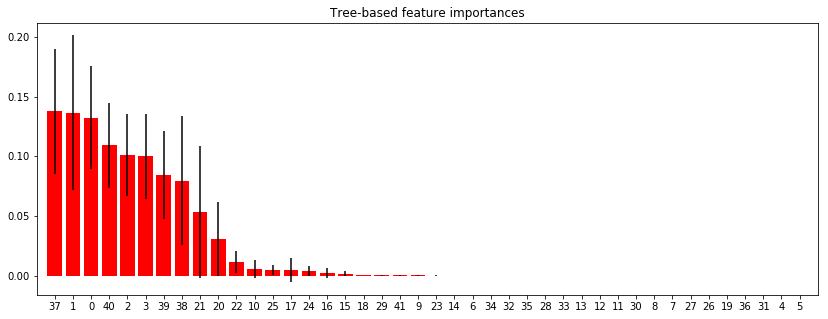

Feature ranking:
 1. ContextCoherenceFeature$bigram                     0.137545 0.0526  0.0850  0.1901
 2. ApproximateContextCoherenceFeature$fivegram        0.136649 0.0647  0.0720  0.2013
 3. ApproximateContextCoherenceFeature$bigram          0.132444 0.0432  0.0893  0.1756
 4. ContextCoherenceFeature$trigram                    0.109013 0.0355  0.0735  0.1445
 5. ApproximateContextCoherenceFeature$fourgram        0.101055 0.0347  0.0663  0.1358
 6. ApproximateContextCoherenceFeature$trigram         0.100054 0.0357  0.0643  0.1358
 7. ContextCoherenceFeature$fourgram                   0.084254 0.0369  0.0474  0.1211
 8. ContextCoherenceFeature$fivegram                   0.079666 0.0540  0.0257  0.1336
 9. CharacterExistenceFeature$45 (-)                   0.053229 0.0554 -0.0022  0.1086
10. CharacterExistenceFeature$44 (,)                   0.030947 0.0310 -0.0000  0.0619
11. CharacterExistenceFeature$46 (.)                   0.011562 0.0094  0.0021  0.0210
12. CharacterExistenceFeat

In [61]:
eval_feat_importances(get_clf('ETree.w2E8.t100'))

In [ ]:
eval_feat_importances(get_clf('GSCV-RF-2'))

In [ ]:
eval_feat_importances(get_clf('GSCV-GradBoost'))

In [ ]:
eval_feat_importances(get_clf('GSCV-GradBoost-2'))

In [ ]:
eval_feat_importances(get_clf('ETree.w3E8.t100'))

In [ ]:
eval_feat_importances(get_clf('GSCV-ETree').best_estimator_)

In [ ]:
eval_feat_importances(get_clf('GSCV-ETree-2').best_estimator_)

In [ ]:
eval_feat_importances(get_clf('GSCV-ETree-full-sqrt').best_estimator_)

In [ ]:
eval_feat_importances(get_clf('GSCV-ETree-full-all').best_estimator_)

In [ ]:
import operator

def eval_opt_feats(rfecv):
    print('Optimal number of features : %d' % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score (nb of correct classifications)')
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    ranked = [(k, v) for k, v in sorted(zip(FEATS_TRAIN.columns, rfecv.ranking_),
                                        key=operator.itemgetter(1))]
    for name, rank in ranked:
        sys.stdout.write('%2s. %s' % (rank, name))
        if 'CharacterExistenceFeature' in name:
            char = chr(int(name[26:]))
            sys.stdout.write(' ' + char)
        print()

In [ ]:
eval_opt_feats(get_clf('RFECV-ETree'))

In [ ]:
eval_opt_feats(get_clf('RFECV-GradBoost'))

## Writeout Results

In [36]:
CLF_NAME = 'ETree.w2E8.t100'

In [44]:
LABEL_PATH = TEMP_PATH + '/detect/label'
OUT_LABEL_TRAIN_PATH = LABEL_PATH + '/labels.train.tsv'
OUT_LABEL_TEST_PATH  = LABEL_PATH + '/labels.test.tsv'
OUT_WORDS_TRAIN_PATH = LABEL_PATH + '/words.train.tsv'
OUT_WORDS_TEST_PATH  = LABEL_PATH + '/words.test.tsv'
OUT_WORDS_TRAIN_SPLIT_PREFIX = LABEL_PATH + '/words.train.tsv.part'
OUT_WORDS_TEST_SPLIT_PREFIX  = LABEL_PATH + '/words.test.tsv.part'

Write out Labels and words that are detected as errors.

In [38]:
if not os.path.exists(LABEL_PATH):
    os.makedirs(LABEL_PATH)

clf = joblib.load(get_pkl_path(CLF_NAME))

# Predict and write train labels.
label_train = clf.predict(FEATS_TRAIN)
with open(OUT_LABEL_TRAIN_PATH, 'w') as f:
    f.write('\n'.join(str(v) for v in label_train))
with open(OUT_WORDS_TRAIN_PATH, 'w') as f:
    word_lines = [l.rstrip() for l in open(WORDS_TRAIN_PATH, 'r').readlines()]
    f.write('\n'.join(word_lines[i] for i, v in enumerate(label_train) if v))

# Predict and write test labels.
label_test = clf.predict(FEATS_TEST)
with open(OUT_LABEL_TEST_PATH, 'w') as f:
    f.write('\n'.join(str(v) for v in label_test))
with open(OUT_WORDS_TEST_PATH, 'w') as f:
    word_lines = [l.rstrip() for l in open(WORDS_TEST_PATH, 'r').readlines()]
    f.write('\n'.join(word_lines[i] for i, v in enumerate(label_test) if v))

Split words into parts

In [54]:
def split(word_file, out_file_prefix):
    word_lines = [l.rstrip() for l in open(word_file, 'r')]
    idx = 1
    remain_lines = word_lines
    while len(remain_lines):
        with open(out_file_prefix + '%02d' % idx, 'w') as file:
            print(len(remain_lines))
            file.write('\n'.join(remain_lines[:1000]))
            remain_lines = remain_lines[1000:]
            idx += 1
            
split(OUT_WORDS_TRAIN_PATH, OUT_WORDS_TRAIN_SPLIT_PREFIX)
split(OUT_WORDS_TEST_PATH, OUT_WORDS_TEST_SPLIT_PREFIX)

12858
11858
10858
9858
8858
7858
6858
5858
4858
3858
2858
1858
858
3006
2006
1006
6
